# Notes

### Dataset MMLU Computer Security:
* https://huggingface.co/datasets/cais/mmlu/viewer/computer_security/test

### Big Mistake in Prompt:
**Added the """ after a linebreak e.g.** <br>
Anwser: <br>
"""<br>
**Correct way:<br>**
Anwser:"""

## Cisco Pass exam
* https://learningnetwork.cisco.com/s/question/0D53i00000U2TO7CAN/what-is-the-pass-percentage-required-to-get-in-ccna-200301
* 825 / 1000 (82 %)
* Every (paid) exam takes 120 min and has about 120 Questions

## HELM  implementation: 
* Max_output tokens to restrict the possible outputs to the max number of answers possibilities
* Temperature = 0
* Joint strategy (all answer choices are presented at once)
* Short Introduction: The following are multiple choice questions (with answers) about computer security.
* (Paper: https://arxiv.org/pdf/2211.09110.pdf)

## HELM / Paper Imprreovements:
* Sampling --> std, mean min / max accuracy

# CCNA 201-301 - 5 Shot like HELM with Answer format: Answer: ABC or Answer: A <br>
### Oberservations Phi:
* Output of Phi-Model always empty, similiar config as mmlu (temp=0, max_output_token = 2), by increasing temp the result of Phi is better but still not close to the other models<br>
* Also have to increase the Max Output Tokens otherwise only \n as response
* Possible approach: Increasing temp and output_tokens, regex pattern that searchs for string in responses
### Oberservations Llama 2:
* LLama 2 results are much worse in comp. to single shot with Correct Answer: ['A', 'B'] and temp =0.7 and no limit to output tokens


## New 

* ~~Yi, Llama 1, Llama 2 (nicht uncensored), Mixtral, Phi-2 --> Für MMLU~~
* Change Answer to Letter (Frage: Exam Answer sind in HELM so, doch ändern?)
* ~~Prompt without whitespace --> extra ~~
* Ungeshuffeld vs HELM Grafik --> HELM vs unsere
* Shuffle (min-max) vs nicht shuffeln
* Dokumentieren --> Prompt, Changes Correct Answer Helm implementierung
* Folien für Präsentation --> Implementierung, Ergebnisse (MMLU ähnlich wie HELM) --> , mit mehr Tokens CCNA Paper (Questionsbank nicht veröffentlicht) --> Weg Cisco (350-701 SCOR), Vetgleich zum Paper
* Alles Dokumentieren
* **How many points to pass? --> Horizontale** 

In [1]:
from templates import *
import time
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
import warnings
import numpy as np
import json
import os
warnings.filterwarnings('ignore')
#Set the output limit to inf
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


In [2]:
## Only for calculation of Probaibliity for CCNA 201-301 Exam ##
# probabilities = []
# for idx, row in CCNA_201_301.iterrows():
#     total_choices = len(row['choices'])
#     correct_answers = len(row['answer'])
    
#     # Wahrscheinlichkeit für eine richtige Antwort
#     probability_one_correct = correct_answers / total_choices
    
#     # Wahrscheinlichkeit für alle richtige Antworten
#     if correct_answers > 1:
#         probability_all_correct = (correct_answers / total_choices) * ((correct_answers - 1) / (total_choices - 1))
#     else:
#         probability_all_correct = probability_one_correct

#     probabilities.append(probability_all_correct)

# # Sume the probabilities list and divide by the number of questions
# probability = sum(probabilities) / len(probabilities)

# probability
probability = 0.5

In [4]:
WORKSPACE_DIC = "/hkfs/work/workspace_haic/scratch/sb7059-llm_models_jeremy"

MODEL_PATH = { #"Mixtral-8x-7b": WORKSPACE_DIC + "/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               #"Phi-2": WORKSPACE_DIC + "/phi-2.Q5_K_M.gguf",
               #"Llama2-70b": WORKSPACE_DIC + "/llama-2-70b.Q5_K_M.gguf",
               #"Yi-34b": WORKSPACE_DIC +  "/yi-34b-200k.Q5_K_M.gguf",
               "LLama-3-70b": WORKSPACE_DIC + "/Llama/LLama3/Meta-Llama-3-70B-Instruct-v2.Q4_K_M.gguf",
               #"Phi-3-medium-128k": WORKSPACE_DIC + "/Phi-3-mini-4k-instruct-q4.gguf",
               #"Mixtral-8x22b": WORKSPACE_DIC + "/mixtral-8x22b-instruct-v0.1.Q4_K_M.gguf",
               #"Mixtral-8x-22b": WORKSPACE_DIC + "/Mixtral/Mixtral-8x22B-Instruct-v0.1.Q4_K_M-00001-of-00002.gguf",
              }

########### Set the model parameters here ############

#Parameter for changing the temperature of the model
TEMPERATURE = 0
#Parameter for max output tokens (for MMLU choose 1, since only Single choice)
MAX_OUTPUT_TOKENS = 2

######################################################

#Sampling rate determines how often a question is asked again if the answer format is wrong
MAX_SAMPLING_RATE = 5

#Set to 1 if you dont want to shuffle
NUM_OF_SHUFFLES = 5

NUMBER_OF_QUESTIONS = 117

########### Set the names for result / evaluation files here ############

############# Turn of / off tracking of results and prints ############
TRACK_RESULTS = True
PRINT_RESULTS = True
######################################################
DATASET_NAME = "350-701-CCNP"
#Set output path
OUTPUT_PATH = f"../results/{NUMBER_OF_QUESTIONS}_questions_5_Shot_{DATASET_NAME}/"

#Set output file name
OUTPUT_EVALUATION = f"{OUTPUT_PATH}llm_5_Shot_{DATASET_NAME}.pkl"

#Filename output evaluation detailed
OUTPUT_EVALUATION_DETAILED = f"../results/{NUMBER_OF_QUESTIONS}_questions_5_Shot_{DATASET_NAME}/llm_prob_result_detailed_{DATASET_NAME}_5_Shot.pkl"

#Set filename of json file
OUTPUT_EVALUATION_JSON = f"../results/{NUMBER_OF_QUESTIONS}_questions_5_Shot_{DATASET_NAME}/llm_prob_result_{DATASET_NAME}_5_Shot.json"


########### Set the names for result files here ############
#Create Folder for results if not exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


########### Set the questionsbank here ############
#Set the questionsbank
#QUESTIONS_BANK = "../data/201-301-CCNA.parquet" ##CCNA
#QUESTIONS_BANK = "../data/mmlu_Computer_Security.parquet" ##CCNA
#QUESTIONS_BANK = "../data/350-701-CCNP.parquet" ##CCNP
QUESTIONS_BANK = "../data/350-701-CCNP_no_image.parquet" ##CCNP no Images
HELM_RESULT = pd.read_pickle("../data/official_sec_mmlu_results.pkl")
########### Set the questionsbank here ############

########### Set the prompt template here ############
PROMPT_TEMPLATE = CCNA_5_SHOT_TEMPLATE_NO_WHITESPACE_AT_FINAL_ANW
########### Set the prompt template here ############

In [5]:
# import llama_cpp
# model = llama_cpp.Llama(model_path= WORKSPACE_DIC + "/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf", n_gpu_layers=128,
#         n_batch=512,
#         n_ctx=1100,
#         temperature=TEMPERATURE,
#         top_p=1,
#         max_tokens = MAX_OUTPUT_TOKENS,
#         #callback_manager=callback_manager,
#         verbose=True,  # Verbose is required to pass to the callback manager
# )

In [6]:
# #Save the parameters as a JSON file
if TRACK_RESULTS:
    parameters = {
        "RUN_NAME": DATASET_NAME,  # Ersetzen Sie durch den tatsächlichen Wert
        "QUESTION_BANK": QUESTIONS_BANK,  # Ersetzen Sie durch den tatsächlichen Wert
        "MAX_SAMPLING_RATE": MAX_SAMPLING_RATE,  # Ersetzen Sie durch den tatsächlichen Wert
        "NUM_OF_SHUFFLES": NUM_OF_SHUFFLES,  # Ersetzen Sie durch den tatsächlichen Wert
        "FEW_SHOT_TEMPLATE": PROMPT_TEMPLATE,  # Ersetzen Sie durch den tatsächlichen Wert
        "TEMPERATURE": TEMPERATURE,  # Ersetzen Sie durch den tatsächlichen Wert
        "MAX_TOKENS": MAX_OUTPUT_TOKENS  # Ersetzen Sie durch den tatsächlichen Wert
    }

    # Speichern Sie das Wörterbuch als JSON-Datei
    with open(OUTPUT_EVALUATION_JSON, 'w') as f:
        json.dump(parameters, f)

In [7]:
def extract_answer(answer):
    """Extracts the correct answers from the provided answer string.

    Args:
        answer: The answer string to extract the correct answers from.

    Returns:
        A list of correct answers (e.g., ['A', 'B']) if found, otherwise None. 
    """
    #print(repr(answer))
    answer = re.sub(r'[\s\n.,]', '', answer)
    pattern = re.compile(r'^[A-Z,]*$')
    #print(answer)
    if re.match(pattern, answer):
        if ',' in answer:
            return None
        else:
            return list(answer)
    else:
        return None
    
def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """
    # Convert answer_exam_list from letters to numbers
    answerLLM = [ord(answer) - 65 for answer in answerLLM]

    # Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam)

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True

    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def format_choices_for_llm(choices):
    #Define the letters for the choices
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    # Erstellen Sie den formatierten String
    formatted_choices = '\n'.join(f'{letters[i]}. {choice}' for i, choice in enumerate(choices))
    
    return formatted_choices

def evaluation_sampling(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_answer(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly
    else:
         return -1


def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Accuracy and Recall and f1 score
    accuracy = correctly_answered / number_of_questions
    accuracy_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Accuracy': accuracy,
        'Accuracy Partial': accuracy_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation_CCNA(evaluation_df, hline_accuracy=None, hline_partial=None, title=None):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define a list of colors for the models
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Accuracy ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[0].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Mean'] - evaluation_df.loc[i, 'Accuracy Min'])], [abs(evaluation_df.loc[i, 'Accuracy Max'] - evaluation_df.loc[i, 'Accuracy Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=12)
    axs[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()
    axs[0].set_ylim([0, 1])
    axs[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        axs[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Partial Mean'] - evaluation_df.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df.loc[i, 'Accuracy Partial Max'] - evaluation_df.loc[i, 'Accuracy Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[1].set_ylabel('Accuracy Partial (%)')
    axs[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=12)
    axs[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[1].legend()
    axs[1].set_ylim([0, 1])
    axs[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        axs[1].axhline(y=hline_partial, color='r', linestyle='--')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()

def calculate_model_statistics(df):
    """
    Calculates statistics for each model in the DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing evaluation metrics for different models.
    
    Returns:
    DataFrame: New DataFrame containing calculated statistics for each model.
    """
    model_stats = []
    for model, group_df in df.groupby('Model'):
        model_stat = {
            'Model': model,
            'Accuracy Mean': group_df['Accuracy'].mean(),
            'Accuracy Max': group_df['Accuracy'].max(),
            'Accuracy Min': group_df['Accuracy'].min(),
            'Accuracy STD': group_df['Accuracy'].std(),
            'Accuracy Partial Mean': group_df['Accuracy Partial'].mean(),
            'Accuracy Partial Max': group_df['Accuracy Partial'].max(),
            'Accuracy Partial Min': group_df['Accuracy Partial'].min(),
            'Accuracy Partial STD': group_df['Accuracy Partial'].std()
        }
        model_stats.append(model_stat)
    
    return pd.DataFrame(model_stats)


def shuffle_choices_and_update_answer(choices, answer):
    # Erstellen Sie eine Liste von Indizes und mischen Sie sie
    indices = list(range(len(choices)))
    random.shuffle(indices)
    
    # Verwenden Sie die gemischten Indizes, um die Auswahlmöglichkeiten und die Antwort zu aktualisieren
    shuffled_choices = [choices[i] for i in indices]
    updated_answer = [indices.index(a) for a in answer]  # Entfernen Sie +1, um 0-basierte Indizes zu verwenden
    
    return shuffled_choices, updated_answer

def plot_evaluation_MMLU(llm_result_df, helm_result, df1_name, df2_name, title=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy'
    """

    # Define colors for the models
    color_llm_result = 'b'
    color_helm_result = 'orange'

    # Define bar width and gap
    bar_width = 0.2  # Decrease bar width for side-by-side bars with a gap
    gap = 0.05  # Define gap between bars

    # Merge the two dataframes by column Model and create a new dataframe and rename the column Accuracy Mean to Accuracy Mean LLM and Accuracy to Accuracy HELM
    llm_result_df = pd.merge(llm_result_df, helm_result, on='Model', suffixes=('_LLM', '_HELM'))
    llm_result_df = llm_result_df.rename(columns={'Accuracy': 'Accuracy_HELM', 'Accuracy Mean': 'Accuracy_Mean_LLM'})

    display(llm_result_df)

    # Just one plot
    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model in enumerate(llm_result_df['Model']):
        bars_llm = ax.bar(i - bar_width - gap / 2, llm_result_df.loc[i, 'Accuracy_Mean_LLM'], bar_width, color=color_llm_result)
        bars_helm = ax.bar(i + gap / 2, llm_result_df.loc[i, 'Accuracy_HELM'], bar_width, color=color_helm_result)

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy Mean LLM vs. HELM', fontsize=12)
    ax.set_xticks([i for i in range(len(llm_result_df['Model']))])
    ax.set_xticklabels(llm_result_df['Model'], rotation=45, ha='right', fontsize=10)
    ax.legend([bars_llm, bars_helm], [df1_name, df2_name])
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    ax.axhline(y=probability, color='r', linestyle='--')

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()

In [8]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])

questions  = pd.read_parquet(QUESTIONS_BANK)

#Randomly take 120 questions
questions = questions.sample(n=NUMBER_OF_QUESTIONS)

#Take the first 20 questions
#questions = questions.head(20)

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(PROMPT_TEMPLATE)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    print("Load Model ...")
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=-1,
        n_batch=512,
        n_ctx=1100,
        temperature=TEMPERATURE,
        top_p=1,
        max_tokens = MAX_OUTPUT_TOKENS,
        #callback_manager=callback_manager,
        verbose=True,  # Verbose is required to pass to the callback manager
    )
    print("Model loaded")
    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        
        #Start the timer
        start_time = time.time()
        for index_question, row in questions.iterrows():
            question = row['question']
            choices = row['choices']
            answers = row['answer']
            num_of_correct_answer = len(answers)

            choices = format_choices_for_llm(choices)

            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices_and_update_answer(row['choices'], row['answer'])
                num_of_correct_answer = len(answers)
                choices = format_choices_for_llm(choices)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices              
                

                ########### Print the question and choices ############
                #print(f"Question: {question}")
                #print(choices)

                llm_answer = chain.invoke({"Exam_Question" : row['question'], "Exam_Choices" : choices})     
                #print(llm_answer)       
                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True
                    break
            
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False

        if PRINT_RESULTS:
            display(llm_exam_result)

        if TRACK_RESULTS:
            llm_exam_result.to_pickle(f"{OUTPUT_PATH}{NUMBER_OF_QUESTIONS}_questions_{DATASET_NAME}_{model}_shuffled_{shuffled_iteration}.pkl")
       
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)

        if PRINT_RESULTS:
            display(shuffled_evalutation_df)

        end_time = time.time()
        elapsed_time = end_time - start_time


        if PRINT_RESULTS:
            print("Time taken:", elapsed_time, "seconds")


#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)

if PRINT_RESULTS:
    display(model_statistics)

#plot_evaluation_MMLU(model_statistics, HELM_RESULT, "Own Approach", "HELM", title="Own Approach vs. HELM Official")
if TRACK_RESULTS:
    shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
    model_statistics.to_pickle(OUTPUT_EVALUATION)


Load Model ...


ValidationError: 1 validation error for LlamaCpp
__root__
  Could not load Llama model from path: /hkfs/work/workspace_haic/scratch/sb7059-llm_models_jeremy/Meta-Llama-3-70B-Instruct-v2.Q4_K_M.gguf. Received error Model path does not exist: /hkfs/work/workspace_haic/scratch/sb7059-llm_models_jeremy/Meta-Llama-3-70B-Instruct-v2.Q4_K_M.gguf (type=value_error)

In [ ]:
for model, model_path in MODEL_PATH.items():
    print(f"Model: {model}")
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.read_pickle(f"{OUTPUT_PATH}{NUMBER_OF_QUESTIONS}_questions_{DATASET_NAME}_{model}_shuffled_{shuffled_iteration}.pkl")
        #llm_exam_result = pd.read_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)

Model: Mixtral-8x-7b
Model: Llama2-70b
Model: Yi-34b
Model: LLama-3-70b
Model: Phi-3-medium-128k


,Model,Accuracy Mean,Accuracy Max,Accuracy Min,Accuracy STD,Accuracy Partial Mean,Accuracy Partial Max,Accuracy Partial Min,Accuracy Partial STD
0,LLama-3-70b,0.606838,0.606838,0.606838,0.0,0.642857,0.642857,0.642857,0.0
1,Llama2-70b,0.452991,0.452991,0.452991,0.0,0.542857,0.542857,0.542857,0.0
2,Mixtral-8x-7b,0.564103,0.564103,0.564103,0.0,0.614286,0.614286,0.614286,0.0
3,Phi-3-medium-128k,0.495726,0.495726,0.495726,0.0,0.635714,0.635714,0.635714,0.0
4,Yi-34b,0.410256,0.410256,0.410256,0.0,0.485714,0.485714,0.485714,0.0


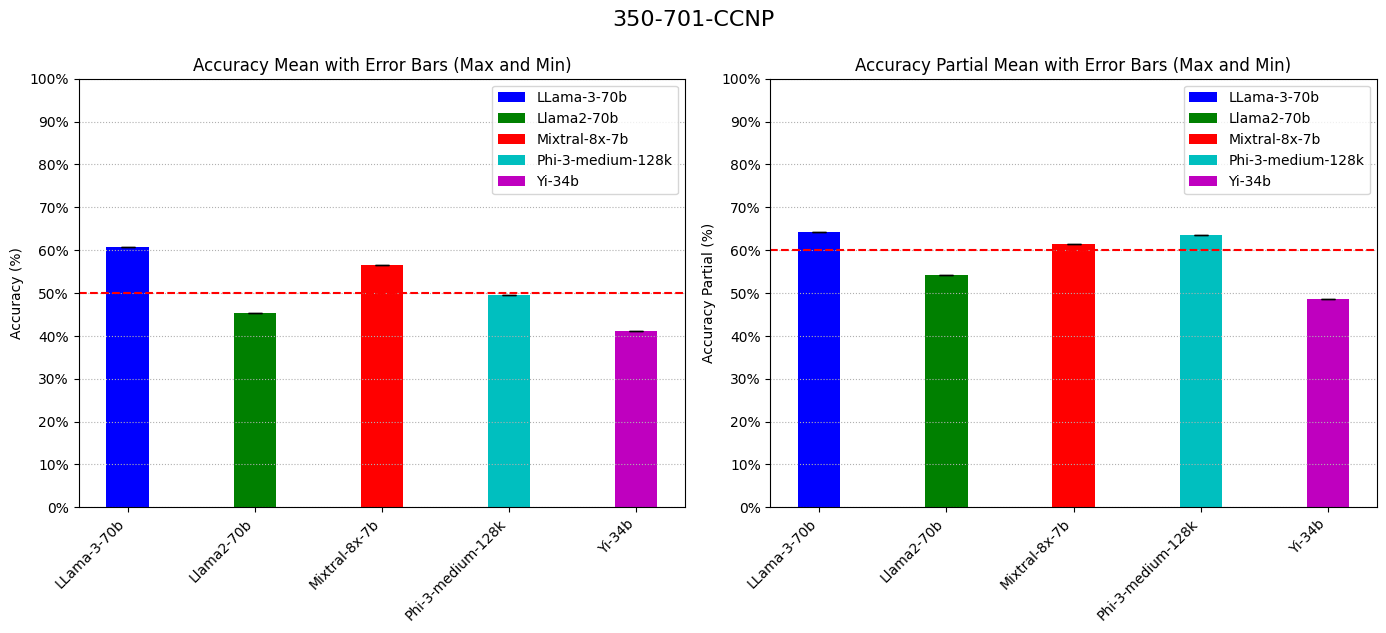

In [9]:
plot_evaluation_CCNA(model_statistics, hline_accuracy=probability, hline_partial=probability+0.1, title=DATASET_NAME)